In [1]:
#importing libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score




In [2]:
# Reading data

df = pd.read_csv('Reviews.csv')
data = df

In [3]:
#Removing neutral reviews
data_s = data[data['Score']!=3]

In [4]:
def partition(x):
    if x<3:
        return 0
    return 1

score_upd = data_s['Score']
temp = score_upd.map(partition)
data_s['Score'] = temp

In [5]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))

In [6]:
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [7]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
final = final.sort_values(['Time'], axis=0)
final = final.head(30000)

In [9]:
final_X = final['Text']
final_y = final['Score']

In [10]:
final_y.value_counts()

1    26762
0     3238
Name: Score, dtype: int64

In [12]:
import re
temp_1 =[]
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(final_X)
for sentence in final_X:
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]
    temp_1.append(words)
    print("{0:.2f} %".format((i/N)*100),end ='\r')
    i = i+1
    
final_X = temp_1   

In [13]:
sent = []
for row in final_X:
    seq = ''
    for word in row:
        seq = seq + ' ' + word
    sent.append(seq)

final_X = sent

**Splitting data**

In [14]:
X_train = final_X[:22000]
X_test = final_X[22000:]
y_train = final_y[:22000]
y_test = final_y[22000:]

**KNN on BoG**

In [15]:
# Bag of Words

count_vect = CountVectorizer(max_features = 5000)
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

**Brute force algorithm**

In [16]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'brute')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv =3 , n_jobs = 2)
grid.fit(bow_X_train, y_train)
print("best k = ", grid.best_params_)

best k =  {'n_neighbors': 7}


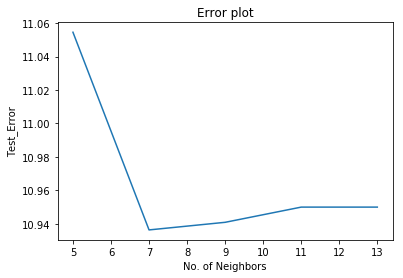

In [17]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [18]:
print("Accuracy on train data= ", grid.best_score_*100)
tr_acc1 = grid.best_score_*100
a = grid.best_params_
optimal_k1 = a.get('n_neighbors')

Accuracy on train data=  89.06363636363636


In [19]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k1 , algorithm = 'brute')

# fitting the model
knn_optimal.fit(bow_X_train, y_train)

# predict the response
pred = knn_optimal.predict(bow_X_test)

# evaluate accuracy
acc1 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k1, acc1))


The accuracy of the knn classifier for k = 7 is 89.937500%


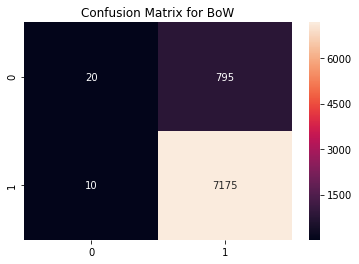

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

**kd_tree algorithm**

In [21]:
tsvd = TruncatedSVD(n_components=1000)
trnc_bow_train = tsvd.fit_transform(bow_X_train)
trnc_bow_test = tsvd.transform(bow_X_test)

In [22]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(trnc_bow_train, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc2 = grid.best_score_*100
a = grid.best_params_
optimal_k2 = a.get('n_neighbors')

best k =  {'n_neighbors': 11}
Accuracy on train data =  89.13636363636364


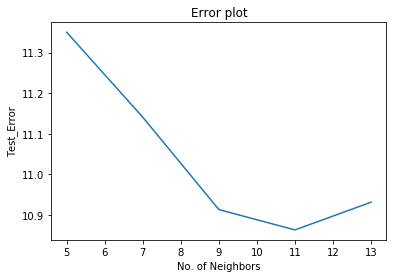

In [23]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [24]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k2 , algorithm = 'kd_tree',)

# fitting the model
knn_optimal.fit(trnc_bow_train,y_train)

# predict the response
pred = knn_optimal.predict(trnc_bow_test)

# evaluate accuracy
acc2 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k2, acc2))


The accuracy of the knn classifier for k = 11 is 89.975000%


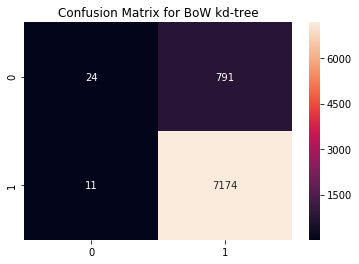

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW kd-tree')
plt.show()

**KNN on TF-IDF**

In [26]:
#using TF-IDF for text to numerical conversion

tf_idf = TfidfVectorizer(max_features=5000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

**Brute force method**

In [27]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'brute')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3)
grid.fit(tf_X_train, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc3 = grid.best_score_*100
a = grid.best_params_
optimal_k3 = a.get('n_neighbors')

best k =  {'n_neighbors': 9}
Accuracy on train data =  89.64090909090909


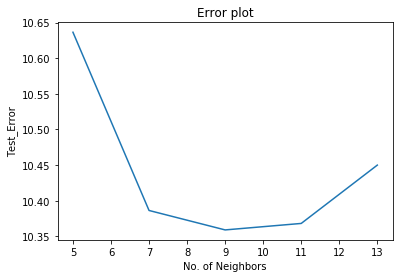

In [28]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [29]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k3 , algorithm = 'brute')

# fitting the model
knn_optimal.fit(tf_X_train, y_train)

# predict the response
pred = knn_optimal.predict(tf_X_test)

# evaluate accuracy
acc3 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k3, acc3))


The accuracy of the knn classifier for k = 9 is 90.375000%


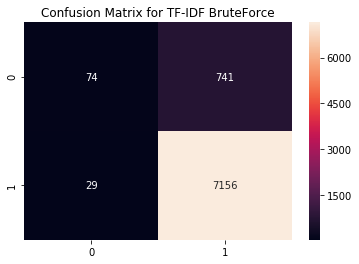

In [30]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF BruteForce')
plt.show()

**kd_tree algorithm**

In [31]:
tsvd = TruncatedSVD(n_components=1000)
trnc_tf_train = tsvd.fit_transform(tf_X_train)
trnc_tf_test = tsvd.transform(tf_X_test)

In [32]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(trnc_tf_train, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc4 = grid.best_score_*100
a = grid.best_params_
optimal_k4 = a.get('neighbors')

best k =  {'n_neighbors': 13}
Accuracy on train data =  89.03181818181818


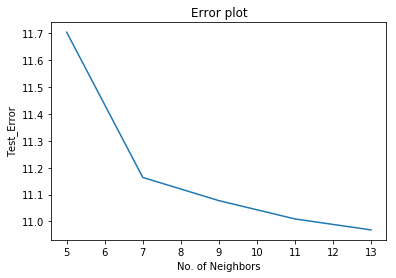

In [33]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [41]:
optimal_k4 = a.get('n_neighbors')

In [42]:
optimal_k4

13

In [43]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k4 , algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(trnc_tf_train, y_train)

# predict the response
pred = knn_optimal.predict(trnc_tf_test)

# evaluate accuracy
acc4 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k4, acc4))


The accuracy of the knn classifier for k = 13 is 89.812500%


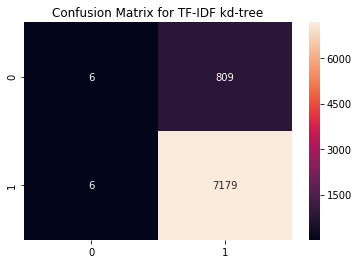

In [44]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF kd-tree')
plt.show()

In [45]:
del bow_X_train
del bow_X_test
del trnc_bow_train
del trnc_bow_test
del tf_X_train
del tf_X_test
del trnc_tf_train
del trnc_tf_test 

**KNN on Avg Word2vec**

In [46]:
w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_test.append(vec/count)

**Brute force method**

In [47]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'brute')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(avg_X_train, y_train)

print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc5 = grid.best_score_*100
a = grid.best_params_
optimal_k5 = a.get('n_neighbors')

best k =  {'n_neighbors': 13}
Accuracy on train data =  89.4


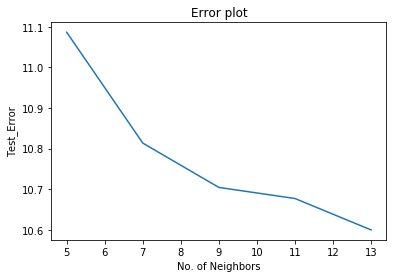

In [48]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [49]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k5 , algorithm = 'brute', n_jobs = 2)

# fitting the model
knn_optimal.fit(avg_X_train, y_train)

# predict the response
pred = knn_optimal.predict(avg_X_test)

# evaluate accuracy
acc5 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k5, acc5))


The accuracy of the knn classifier for k = 13 is 89.800000%


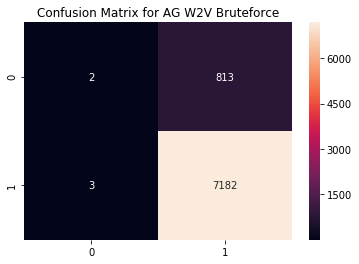

In [50]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for AG W2V Bruteforce')
plt.show()

**kd_tree algorithm**

In [51]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(avg_X_train, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc6 = grid.best_score_*100
a = grid.best_params_
optimal_k6 = a.get('neighbors')

best k =  {'n_neighbors': 13}
Accuracy on train data =  89.4


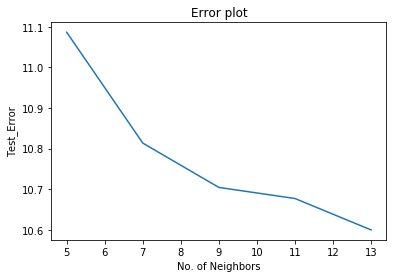

In [52]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [54]:
optimal_k6 = a.get('n_neighbors')

In [55]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k6 , algorithm = 'kd_tree', n_jobs = 2)

# fitting the model
knn_optimal.fit(avg_X_train, y_train)

# predict the response
pred = knn_optimal.predict(avg_X_test)

# evaluate accuracy
acc6 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k6, acc6))


The accuracy of the knn classifier for k = 13 is 89.800000%


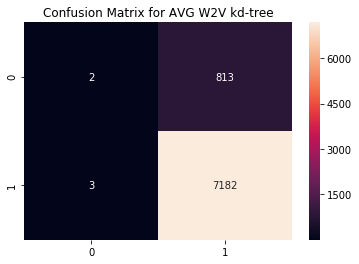

In [56]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for AVG W2V kd-tree')
plt.show()

In [57]:
del avg_X_train
del avg_X_test

**KNN on TF-IDF AVG WORD2VEC**

In [58]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=5000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

**Brute force algorithm**

In [59]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'brute')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(tf_train_data, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc7 = grid.best_score_*100
a = grid.best_params_
optimal_k7 = a.get('n_neighbors')

best k =  {'n_neighbors': 13}
Accuracy on train data =  88.82272727272728


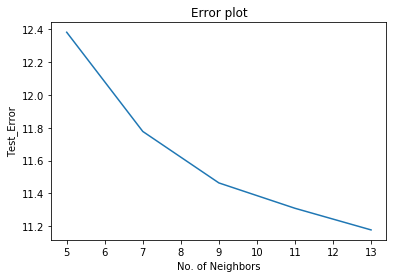

In [60]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [61]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k7 , algorithm = 'brute', n_jobs = 2)

# fitting the model
knn_optimal.fit(tf_train_data, y_train)

# predict the response
pred = knn_optimal.predict(tf_test_data)

# evaluate accuracy
acc7 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k7, acc7))


The accuracy of the knn classifier for k = 13 is 89.662500%


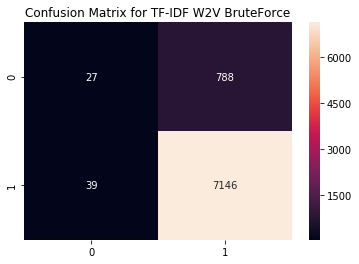

In [62]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF W2V BruteForce')
plt.show()

**kd_tree algorithm**

In [64]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = { 'n_neighbors':np.arange(5,15,2)}
grid = GridSearchCV(estimator = knn, param_grid = param_grid ,cv = 3,  n_jobs = 2)
grid.fit(tf_train_data, y_train)
print("best k = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
tr_acc8 = grid.best_score_*100
a = grid.best_params_
optimal_k8 = a.get('n_neighbors')

best k =  {'n_neighbors': 13}
Accuracy on train data =  88.82272727272728


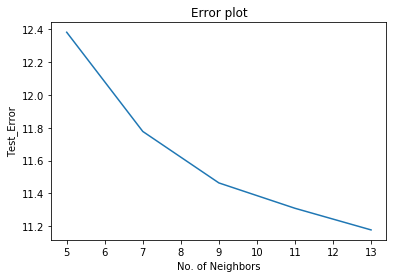

In [65]:
neig = [i for i in range(5,15,2)]
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(neig, error)
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.show()

In [66]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k8 , algorithm = 'kd_tree', n_jobs = 2)

# fitting the model
knn_optimal.fit(tf_train_data, y_train)

# predict the response
pred = knn_optimal.predict(tf_test_data)

# evaluate accuracy
acc8 = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k8, acc8))


The accuracy of the knn classifier for k = 13 is 89.662500%


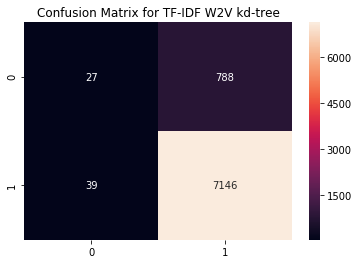

In [67]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF W2V kd-tree')
plt.show()

In [70]:
from prettytable import PrettyTable

x = PrettyTable()

model1 = 'BoW'
model2 = 'TF-IDF'
model3 = 'AVG W2V'
model4 = 'TF-IDF W2V'

type1 = 'Brute'
type2 = 'kd-tree'

x.field_names = ["Model","Algorithm","Optimal K","Train_Error(%)","Test_Error(%)"]

tr_err1 = np.around(100-tr_acc1, decimals =2)
err1 = np.around(100-acc1, decimals = 2)

tr_err2 = np.around(100-tr_acc2, decimals =2)
err2 = np.around(100-acc2, decimals = 2) 

tr_err3 = np.around(100-tr_acc3, decimals =2)
err3 = np.around(100-acc3, decimals = 2) 

tr_err4 = np.around(100-tr_acc4, decimals =2)
err4 = np.around(100-acc4, decimals = 2) 

tr_err5 = np.around(100-tr_acc5, decimals =2)
err5 = np.around(100-acc5, decimals = 2) 

tr_err6 = np.around(100-tr_acc6, decimals =2)
err6 = np.around(100-acc6, decimals = 2) 

tr_err7 = np.around(100-tr_acc7, decimals =2)
err7 = np.around(100-acc7, decimals = 2) 

tr_err8 = np.around(100-tr_acc8, decimals =2)
err8 = np.around(100-acc8, decimals = 2) 




x.add_row([model1,type1,optimal_k1,tr_err1,err1])
x.add_row([model1,type2,optimal_k2,tr_err2,err2])
x.add_row([model2,type1,optimal_k3,tr_err3,err3])
x.add_row([model2,type2,optimal_k4,tr_err4,err4])
x.add_row([model3,type1,optimal_k5,tr_err5,err5])
x.add_row([model3,type2,optimal_k6,tr_err6,err6])
x.add_row([model4,type1,optimal_k7,tr_err7,err7])
x.add_row([model4,type2,optimal_k8,tr_err8,err8])


print(x)

+------------+-----------+-----------+----------------+---------------+
|   Model    | Algorithm | Optimal K | Train_Error(%) | Test_Error(%) |
+------------+-----------+-----------+----------------+---------------+
|    BoW     |   Brute   |     7     |     10.94      |     10.06     |
|    BoW     |  kd-tree  |     11    |     10.86      |     10.02     |
|   TF-IDF   |   Brute   |     9     |     10.36      |      9.62     |
|   TF-IDF   |  kd-tree  |     13    |     10.97      |     10.19     |
|  AVG W2V   |   Brute   |     13    |      10.6      |      10.2     |
|  AVG W2V   |  kd-tree  |     13    |      10.6      |      10.2     |
| TF-IDF W2V |   Brute   |     13    |     11.18      |     10.34     |
| TF-IDF W2V |  kd-tree  |     13    |     11.18      |     10.34     |
+------------+-----------+-----------+----------------+---------------+


**Summary and Observations**

* Considered a sample of 30k datapoints. (Box Running times)
* Plotted Error plots based on K values 
* Shown Confusion Matrix using sns heatmap, Majorly saw most of the points are classifing as positive.
* Used PrettyTable to show all the data as a table manner.
* from the table we can see that TF-IDF on brute force gave less test error compared to other models.
* Intrestingly noted that, on AVG W2V and TF-IDF W2V on both algorithms gave exactly same results.